# Your work here!

In [1]:
import numpy as np 
import pandas as pd
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

from nnViz_pytorch import *
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
%matplotlib inline
!pwd
N = 96 
F = 4
CPU = torch.device('cpu')
device = CPU

/home/irina/Hackathon/environmental-hackathon


In [42]:
test_red = np.load("data/test_data_reduced.npy")
test_red.shape

(9898, 960)

In [3]:
pred_red = np.load("data/test_pred_reduced.npy")
pred_red.shape

(9898, 960)

In [4]:
test = np.load("data/test_data_complete.npy")
test.shape

(9898, 2112)

In [66]:
pred = np.load("data/test_smoo_complete.npy")
pred.shape

(9898, 2112)

In [6]:
a = np.load("anom1.npy")


In [334]:
def deviation(a,b):
    c = np.array(a) - np.array(b)
    # in one window:
    # mse = np.square(c).mean(axis=None)
    # in 2 windows 
    #mse = max([np.square(c[i*N//2:(i+1)*N//2]).mean(axis=None) for i in range(2)])    
    # in 3 overlaping windows 
    mse = max([np.square(c[j:j+N//2]).mean(axis=None) for j in [0, N//4, N//2]])    
    dev = max(abs(c))
    return dev, mse

def column_dev( aa, bb):
    dev = [ deviation(a,b) for a, b in zip(aa, bb)]
    #print(dev)
    return np.array(dev)

def deviation_stats( t, p ):
    dev=np.zeros((t.shape[0], 16))
    mse=np.zeros((t.shape[0], 16))
    dev.shape
    for j in [0,1,2,3]:
        p1 = p[:,j*N:(j+1)*N]
        for i in [0,1,2,3]:
            t1 = t[:,(j*4+i)*N:(j*4+i+1)*N]
            d = column_dev(t1, p1)
            dev[:,j*4+i] = d[:,0]
            mse[:,j*4+i] = d[:,1]
    d = np.zeros((t.shape[0], 4))
    m = np.zeros((t.shape[0], 4))
    
    for i in [0,1,2,3]:
        d[:, i] = np.max(dev[:,i*4:(i+1)*4], axis=1)
        m[:, i] = np.max(mse[:,i*4:(i+1)*4], axis=1)    
            
    return d, m

In [335]:
dev, mse = deviation_stats(test, test_red)
dev = np.array(dev)
dev.shape
d1 = test[20]            # regular
d2 = test[5502]          # brocken sensor
d3 = test[3050]          # deviates strongly
d4 = test[9298]   

In [336]:
#d5,m5 = deviation_stats(test[:5], test_red[:5]) 
print(d5, m5)

[[0.40878003 0.428045   0.42540508 1.38807498]
 [0.46405356 0.3925347  0.29310396 1.05932739]
 [0.14871175 0.3893549  0.29948196 1.25745702]
 [0.54573213 0.45178882 0.25220906 1.14245912]
 [0.12479523 0.43928706 0.40701881 1.45523423]] [[0.00664113 0.0342465  0.01636961 0.32205615]
 [0.00930677 0.02663463 0.01972071 0.28450169]
 [0.00258501 0.01874951 0.01047443 0.28578626]
 [0.00849446 0.03172967 0.00814759 0.41343305]
 [0.0019417  0.05687678 0.01025319 0.20352392]]


In [337]:
d5,m5 = deviation_stats(test[:5], test_red[:5]) 
print(d5, m5)

#for i  in [20,5502,3050,9298]:
#    print( dev[i], mse[i])

[[0.40878003 0.428045   0.42540508 1.38807498]
 [0.46405356 0.3925347  0.29310396 1.05932739]
 [0.14871175 0.3893549  0.29948196 1.25745702]
 [0.54573213 0.45178882 0.25220906 1.14245912]
 [0.12479523 0.43928706 0.40701881 1.45523423]] [[0.00664113 0.0342465  0.01636961 0.32205615]
 [0.00930677 0.02663463 0.01972071 0.28450169]
 [0.00313862 0.01874951 0.01080982 0.28578626]
 [0.00849446 0.03172967 0.00814759 0.41343305]
 [0.00204403 0.06230942 0.01025319 0.25198496]]


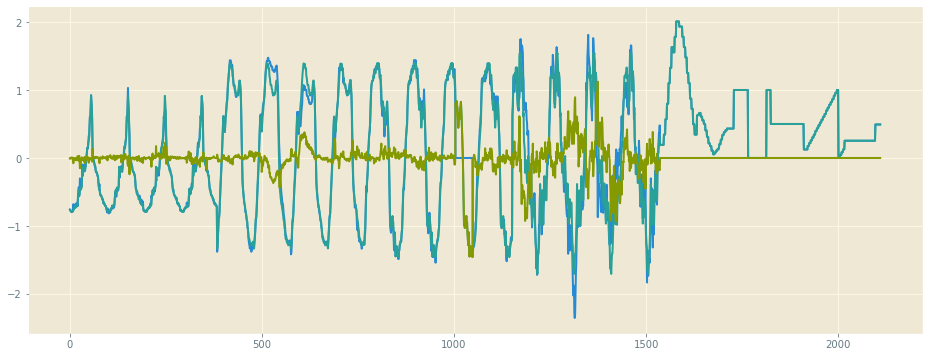

In [338]:
plt.figure(figsize=(16,6));
i = 5502
plt.plot(test[i])
plt.plot(pred[i])
plt.plot(pred[i]-test[i])

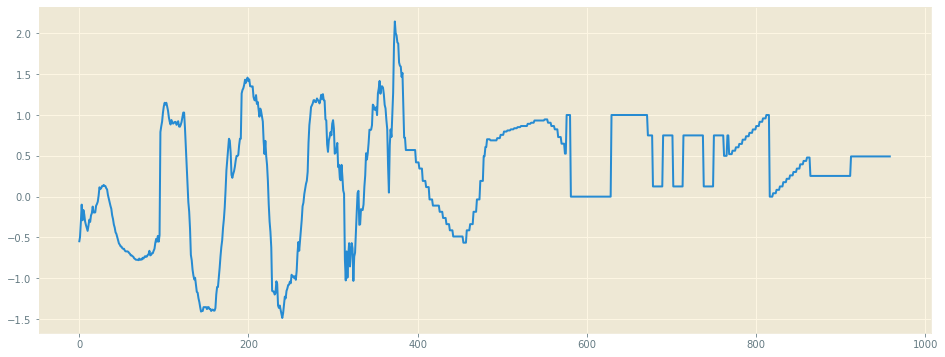

In [339]:
plt.figure(figsize=(16,6));
plt.plot(test_red[20])

In [340]:
def renormalize(s):
#    print("renormalized coeffs:",  s.mean(axis = 0), s.std(axis=0))
    return (s - s.mean(axis = 0))/s.std(axis=0)
    
def find_spikes(seq, th=5):
    seq = renormalize(seq)
    a = [i for i, s in enumerate(seq) if s > th]
    return a

def find_all_spikes(dev, a, th=10):
    anom = []
    anom=np.append(anom,a)
    for c in range(dev.shape[1]): 
   #     print("c=", c)
        seq = renormalize(dev[:,c])
        for i in anom:
            seq[int(i)] = 0.
        a = find_spikes(seq, th)
        anom=np.append(anom,a)
    return anom

In [490]:
def the_curve(seq, a):
    thr = np.linspace(1, 20, num=1000)
    na  = []
    for th in thr:
        ad = find_all_spikes(seq, a, th)
        na.append(len(ad))    
    return thr, na

def the_curve2(a):
    thr = np.linspace(1, 20, num=1000)
    na  = []
    n1  = []
    for th in thr:
        ad = find_all_spikes(dev, a, th)
        n1.append(len(ad))
        ae = find_all_spikes(mse, ad, th)
        na.append(len(ae))    
    return thr, na, n1

In [342]:
dev.shape

(9898, 4)

In [471]:
th=7.1
ad = find_all_spikes(dev, a, th)
print(len(set(ad)))
th=7.06
ae = find_all_spikes(mse, ad, th)
print(len(set(ae)))

156
200


In [510]:
th=3
ad = find_all_spikes(dev, a, th)
print(len(set(ad)))
th=13.3
ae = find_all_spikes(mse, ad, th)
print(len(set(ae)))

190
200


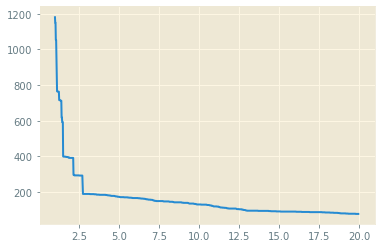

In [491]:
thresholds, outliers = the_curve(dev,a)
plt.plot(thresholds, outliers);


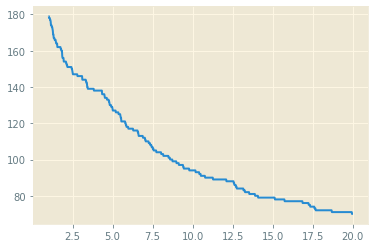

In [492]:
thresholds, outliers = the_curve(mse,a)
plt.plot(thresholds, outliers);

In [493]:
thresholds, out, out1 = the_curve2(a)

(0.0, 300.0)

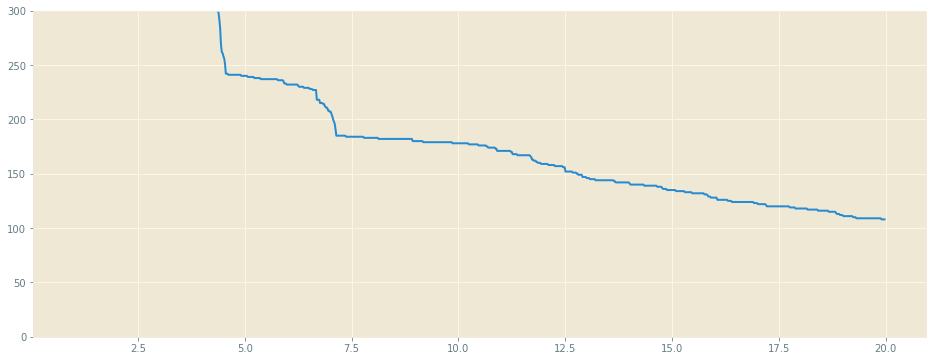

In [495]:
plt.figure(figsize=(16,6));
plt.plot(thresholds, out)
plt.ylim(0,300)
#plt.plot(thresholds, out1)

In [309]:
a

array([  49,  162,  180,  277,  420,  439,  667,  686,  745, 1147, 1358,
       1394, 1621, 1804, 1861, 1940, 3059, 3152, 4009, 4380, 4381, 4695,
       4819, 4870, 5074, 5092, 5158, 5269, 5303, 5502, 5562, 5589, 5778,
       5788, 6066, 6269, 6284, 6303, 6378, 6702, 6940, 7443, 7673, 7688,
       8008, 8103, 8380, 8450, 8623, 8765, 8866, 8983, 9042, 9253, 9654])

In [472]:
def disp_anom(seq, a):
    plt.figure(figsize=(16,6));
    s = renormalize(seq)
    s = [min(10, ss) for ss in s]
    plt.plot(s)
    s = np.array(s)
    a = [int(aa) for aa in a]
    a.sort()
    #print(a)
    plt.plot(a, s[a], "ro")

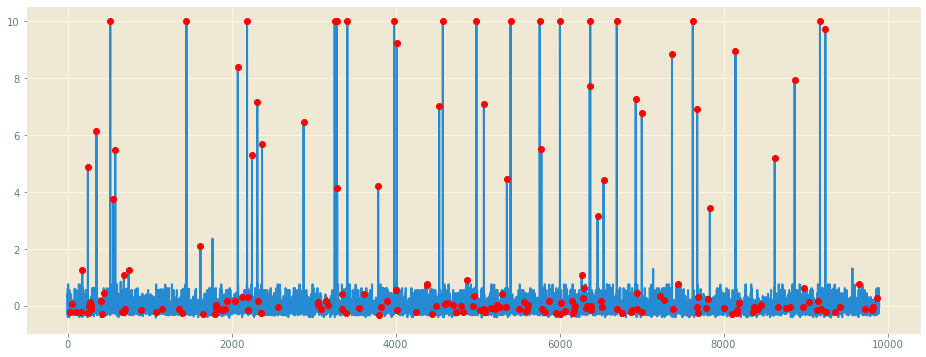

In [496]:
disp_anom(dev[:,0], ad)

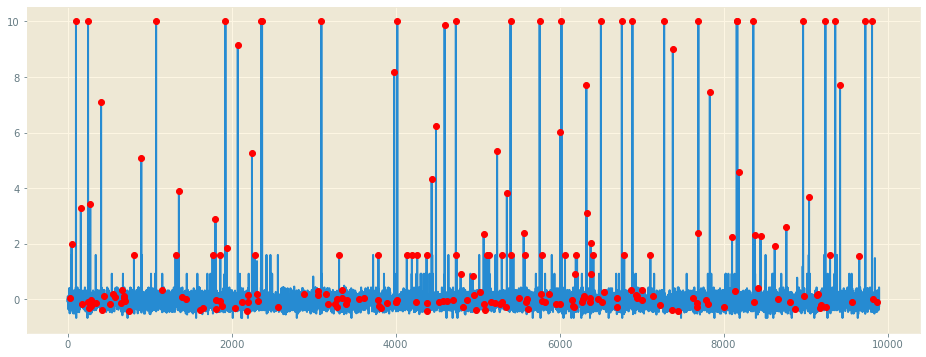

In [497]:
disp_anom(dev[:,1], ae)

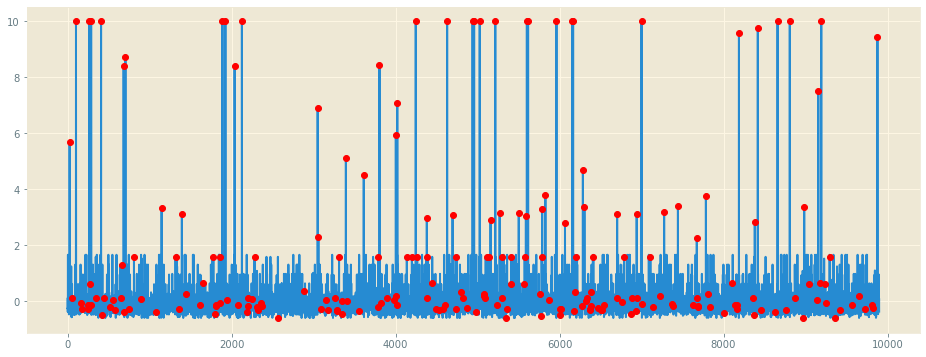

In [498]:
disp_anom(dev[:,2], ae)

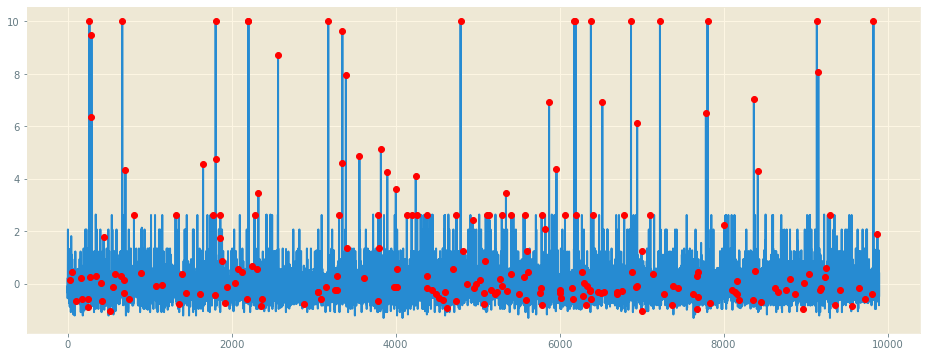

In [499]:
disp_anom(dev[:,3], ae)

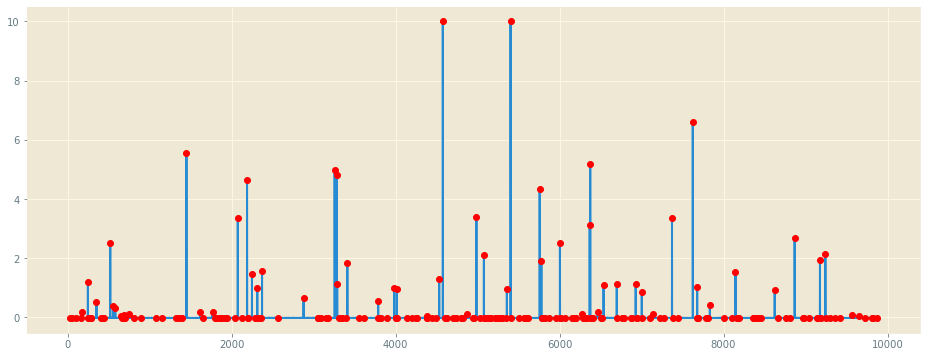

In [500]:
disp_anom(mse[:,0], ae)

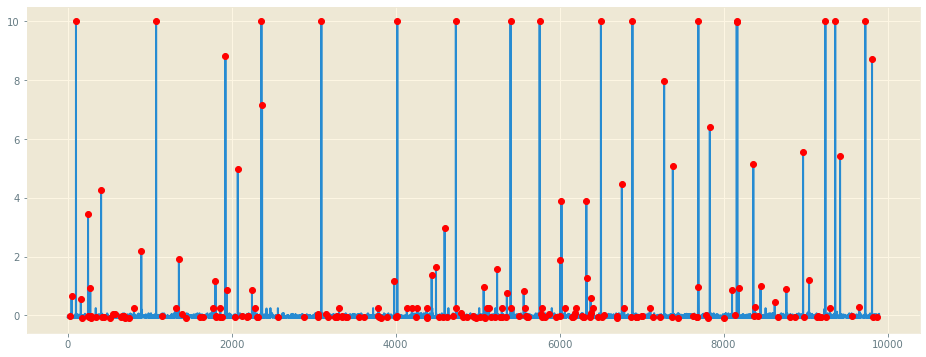

In [501]:
disp_anom(mse[:,1], ae)

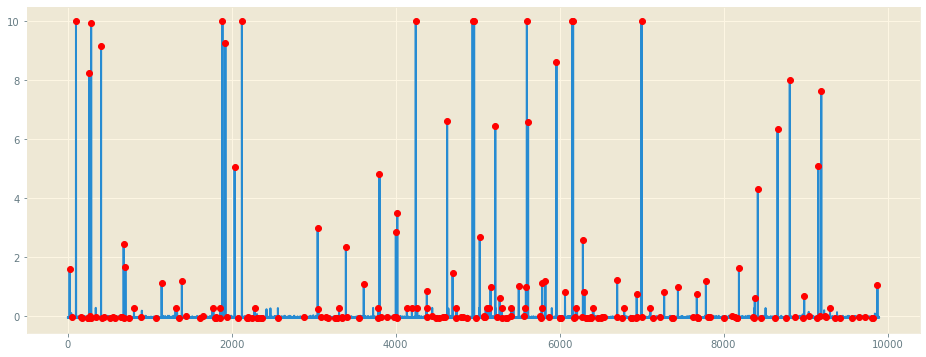

In [502]:
disp_anom(mse[:,2], ae)

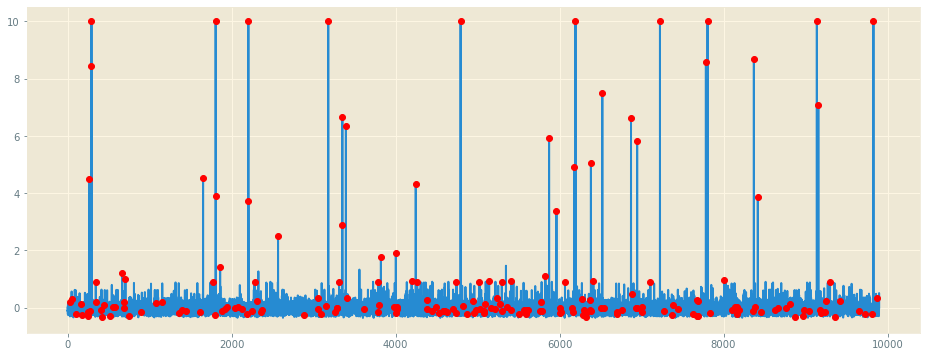

In [318]:
disp_anom(mse[:,3], ae)

In [329]:
#print(len(ad), ad)

In [330]:
#print(len(ae), ae)

In [511]:
print(a)

[  49  162  180  277  420  439  667  686  745 1147 1358 1394 1621 1804
 1861 1940 3059 3152 4009 4380 4381 4695 4819 4870 5074 5092 5158 5269
 5303 5502 5562 5589 5778 5788 6066 6269 6284 6303 6378 6702 6940 7443
 7673 7688 8008 8103 8380 8450 8623 8765 8866 8983 9042 9253 9654]


In [512]:
a2 = [int(i) for i in sorted(list(set(ad).difference(set(a))))]
print(len(a2), a2)

135 [25, 103, 248, 250, 267, 288, 292, 353, 409, 521, 555, 582, 684, 706, 899, 1080, 1450, 1653, 1806, 1807, 1889, 1925, 2037, 2076, 2126, 2189, 2202, 2205, 2249, 2314, 2327, 2364, 2372, 2567, 2878, 3050, 3095, 3179, 3257, 3281, 3288, 3347, 3351, 3394, 3412, 3559, 3612, 3788, 3804, 3821, 3899, 3983, 4003, 4015, 4021, 4246, 4440, 4493, 4532, 4576, 4598, 4629, 4735, 4793, 4939, 4958, 4986, 5026, 5077, 5216, 5238, 5346, 5357, 5402, 5601, 5616, 5757, 5827, 5872, 5962, 6004, 6006, 6023, 6155, 6165, 6178, 6194, 6326, 6333, 6367, 6374, 6382, 6463, 6504, 6521, 6536, 6697, 6759, 6871, 6888, 6928, 6946, 6999, 7002, 7224, 7275, 7371, 7381, 7624, 7678, 7692, 7784, 7804, 7832, 8145, 8160, 8167, 8187, 8362, 8369, 8417, 8658, 8807, 8969, 9137, 9155, 9175, 9191, 9241, 9361, 9420, 9728, 9810, 9827, 9876]


In [513]:
a3 = [int(i) for i in sorted(list(set(ae).difference(set(ad))))]
print(len(a3), a3)
len(a) + len(a2) + len(a3)

10 [648, 810, 1317, 1768, 4137, 4199, 5141, 5413, 7141, 9571]


200

In [514]:
c2 =[ np.argmax(abs(pred[i]-test[i])) for i in a2]    

In [515]:
print(c2)
np.save("spikes.npy", (a2,c2))

[801, 768, 1, 453, 1141, 1205, 1283, 278, 848, 270, 297, 207, 1047, 1149, 615, 691, 200, 1481, 1422, 1374, 801, 814, 890, 372, 798, 348, 1210, 1307, 300, 1, 1424, 601, 675, 1266, 35, 768, 485, 1239, 288, 173, 260, 1394, 1469, 1191, 154, 1358, 1120, 311, 913, 1197, 1445, 365, 1189, 271, 736, 1104, 627, 692, 13, 224, 732, 1057, 562, 1174, 1087, 1065, 56, 1027, 241, 969, 450, 1398, 95, 377, 885, 924, 388, 1180, 1505, 1110, 139, 716, 640, 1132, 976, 1495, 1322, 440, 609, 281, 171, 1211, 70, 703, 1267, 184, 282, 481, 1391, 442, 233, 1494, 904, 327, 1363, 715, 38, 564, 161, 104, 458, 1171, 1159, 456, 367, 702, 486, 785, 509, 1406, 1106, 1146, 1088, 647, 1345, 1455, 186, 934, 372, 736, 739, 562, 693, 1278, 1150]


In [516]:
print(96*16, max(c2))

1536 1505


In [592]:
c3 = []
ce = []
v = 0 
for i in a3:
    c = pred[i]-test[i]
    va = 0 
    for k in range(16):
        t = []
        for j in [0, N//4, N//2]:
            i1 = j+k*N 
            i2 = j+k*N+N//2
            t1  = np.square(c[i1:i2]).mean(axis=None)
            t.append(t1)
        val = max(t)
        if val > va:
            va = val
            e  = np.argmax(t) * 4*k
    c3.append((e+1)*N//4)
    ce.append(e)

In [593]:
print(ce)

[56, 52, 52, 0, 52, 0, 0, 0, 112, 52]


In [1]:
plt.figure(figsize=(16,6));
i = a3[-3]
#plt.plot(test[i])
#plt.plot(pred[i])

plt.plot(np.square(pred[i]-test[i]))
plt.plot(c3[-3], 0, "ro")

NameError: name 'plt' is not defined

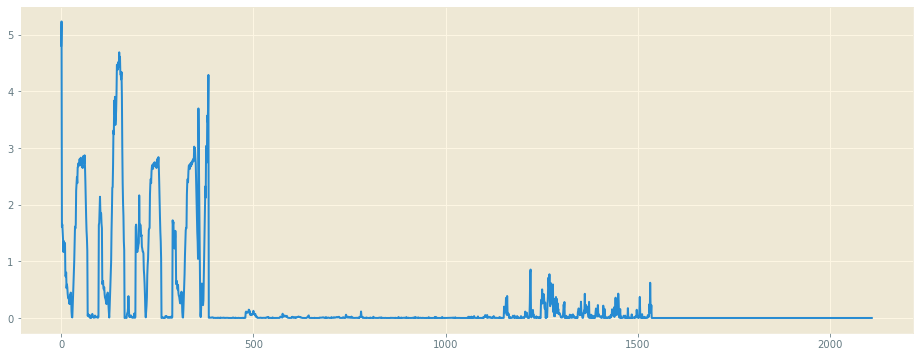

In [206]:
plt.figure(figsize=(16,6));
#[np.square(c[i*N//2:(i+1)*N//2]).mean(axis=None)
c = pred[i]-test[i] 
plt.plot(np.square(c)) 
 

In [207]:
[np.square(c[j:j+N//2]).mean(axis=None) for j in range(32)]

[1.296652726148453,
 1.2552770016289092,
 1.2027154866833234,
 1.2256188592512884,
 1.2501932736178867,
 1.2748916159398942,
 1.3029879136528055,
 1.3343843956495356,
 1.3622687298671448,
 1.3916909514191547,
 1.4242400166751779,
 1.4551114177739304,
 1.4981782165079256,
 1.5398301846792517,
 1.5829179134452616,
 1.6275362497108947,
 1.6652505387820977,
 1.6966511017209462,
 1.7248672811713615,
 1.74950883717692,
 1.771717620543993,
 1.7891329282050439,
 1.7845706738195986,
 1.7808490942519761,
 1.7731879718178531,
 1.765241847612991,
 1.756451516744633,
 1.7502585732003995,
 1.748015888916644,
 1.7476898724966035,
 1.7475111930153329,
 1.7437747751016335]

In [214]:
print(np.square(c[0:N//2]))
(np.square(c[0:N//2])).mean(axis=None) 


[4.78995086 5.23323241 1.61091781 1.64870614 1.50945456 1.37038142
 1.16403021 1.35652695 1.2349795  1.29036403 1.32375125 0.73837217
 0.73338567 0.80256091 0.52594056 0.59184806 0.54060906 0.42537191
 0.35967006 0.34236893 0.35224288 0.25945465 0.24479234 0.40594603
 0.40607008 0.44770395 0.35206798 0.11139888 0.01571366 0.01004139
 0.18031964 0.39475699 0.58509029 0.76767818 1.00244425 1.32338842
 1.6109817  1.57984324 1.64801799 2.24855312 2.37955215 2.4824265
 2.37955215 2.66300956 2.6676207  2.73120033 2.68644938 2.71059192]


1.296652726148453

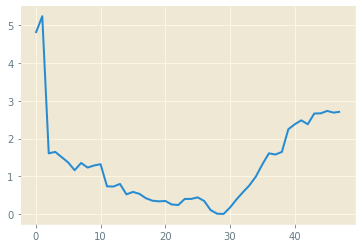

In [215]:
plt.plot(np.square(c[0:N//2])) 

In [ ]:
#a1, c1 = broken_sensor(fixed,20)
#print(a1, c1)
#anomaly_1 = np.array([test[i, :] for i in a])
for i, j in enumerate(a):
    test[j, :] = fixed[i, :] 

In [ ]:
Anomaly1 = a
np.save("anom1.npy", Anomaly1)

In [ ]:
plt.figure(figsize=(20,6));
plt.plot(mse4)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sumup

In [ ]:
import inspect
lines = inspect.getsource(sumup)
print(lines)

In [ ]:
sns.distplot(mse2/sum(mse2))

In [ ]:
sns.distplot(mse3/sum(mse3))

In [ ]:
sns.distplot(mse4/sum(mse4))


In [ ]:
print(sum(mse1), sum(mse2), sum(mse3), sum(mse4))

In [ ]:
mse = mse1/sum(mse1) + mse2/sum(mse2) + mse3/sum(mse3) + mse4/sum(mse4) 
sns.distplot(mse)

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse)
plt.plot(a, mse[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse1)
plt.plot(a, mse1[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse2)
plt.plot(a, mse2[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse3)
plt.plot(a, mse3[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse4)
plt.plot(a, mse4[a], "ro")

In [ ]:
def thrcurve(err):
    n_outliers = []
    thresholds = []
    n = 100
    maxe = max(err)
    mine = sum(err)/len(err)
    for i in reversed(range(n)):
        th = mine + i *(maxe-mine)/n
        a = len([e for e in err if e >th])
        if a > 300:
            #print(a, th, maxe)
            mine = th
            break
    for i in range(n):
        th = mine + i *(maxe-mine)/n
        n_outliers.append(len([e for e in err if e >th]))
        thresholds.append(th) 
    return thresholds, n_outliers

In [ ]:
thresholds, outliers = thrcurve(mse*10000)
plt.plot(thresholds, outliers)

In [ ]:
th = 0.0015
anom = [i for i, e in enumerate(mse) if e >th]
print(anom, len(anom))


In [ ]:
thresholds, outliers = thrcurve(mse1/sum(mse1)*10000)
plt.plot(thresholds, outliers)

In [ ]:
thresholds, outliers = thrcurve(mse2/sum(mse2)*10000)
plt.plot(thresholds, outliers)

In [ ]:
thresholds, outliers = thrcurve(mse3/sum(mse3)*10000)
plt.plot(thresholds, outliers)

In [ ]:
thresholds, outliers = thrcurve(mse4/sum(mse4)*10000)
plt.plot(thresholds, outliers)

In [ ]:
train_hum = train_red[:, N*3: N*4]
test_hum  = test_red[:,  N*3: N*4]
DL_Train_hum = DataLoader(train_hum.astype('float32'), batch_size=16, shuffle = True )
DL_Test_hum  = DataLoader( test_hum.astype('float32'), batch_size=1 , shuffle = False )
#model_hum, loss_hum = train_model( model, DL_Train_hum, targetDevice, nEpochs)
model_hum, loss_hum = train_model( model_hum, DL_Train_hum, targetDevice, nEpochs)

DL_Train_hum2 = DataLoader(test_hum.astype('float32'), batch_size=16, shuffle = True )
model_hum, loss_hum = train_model( model_hum, DL_Train_hum2, targetDevice, 20) 
torch.save( model_hum, "model_hum.v1.pth")


In [ ]:
plt.figure(figsize=(6,6));
plt.plot(loss_hum)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');


In [ ]:
mse_errors_hum = evaluate_model( model_hum, DL_Test_hum, targetDeviceGPU, len(test_red))
print(len(mse_errors_hum))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_hum)

In [ ]:
plt.plot()